# Joint domain detection in DLPFC dataset

We present our evaluation source code of DLPFC slice 151507 to 151510 in this section.
This tutorial will show you how to obtain DLPFC data from `st_datasets` and how to train stMSA.
If you have more than one GPU in your device, you may need to set the GPU you want, or it will run at GPU:0 by default.

In [1]:
import scanpy as sc

import st_datasets as stds
from train_integrate import train_integration

## Data Preparation

First, we obtain each slice by `st_datasets` and concatenate the four slices.

In [2]:
adata_list = [stds.get_data(stds.get_dlpfc_data, id=i)[0] for i in range(4)]
adatas = sc.concat(adata_list, label='batch')
adatas = adatas[:, adata_list[-1].var['highly_variable']]

>>> INFO: Use local data.
>>> INFO: dataset name: dorsolateral prefrontal cortex (DLPFC), slice: 151507, size: (4226, 33538), cluster: 7.(0.371s)
>>> INFO: Use local data.
>>> INFO: dataset name: dorsolateral prefrontal cortex (DLPFC), slice: 151508, size: (4384, 33538), cluster: 7.(0.274s)
>>> INFO: Use local data.
>>> INFO: dataset name: dorsolateral prefrontal cortex (DLPFC), slice: 151509, size: (4789, 33538), cluster: 7.(0.338s)
>>> INFO: Use local data.
>>> INFO: dataset name: dorsolateral prefrontal cortex (DLPFC), slice: 151510, size: (4634, 33538), cluster: 7.(0.315s)


## Train stMSA

Then, we can uses the adata to generate the latent representation by stMSA.
The adata and the graph construction variable (neighbors number K or radius) or directly provide a graph is compulsory.
You can save your model for later inference by `save_model` variable.  
- We have provided the trained model parameters of stMSA in our [Docker container](https://hub.docker.com/r/hannshu/stmsa) at `/root/stMSA_paras/`

In [3]:
adatas = train_integration(adatas, radius=150, save_model='151507-151510.pt')

>>> INFO: Generate 28996 edges, 5.861 edges per spot.(0.018s)
>>> INFO: Generate 30082 edges, 5.862 edges per spot.(0.164s)
>>> INFO: Generate 32961 edges, 5.883 edges per spot.(0.019s)
>>> INFO: Generate 31832 edges, 5.869 edges per spot.(0.017s)
>>> INFO: Finish generate precluster embedding(6.691s)!


  0%|          | 1/500 [00:03<28:31,  3.43s/it]

>>> INFO: Finish finding mmn pairs, find 989103 mnn node pairs(2.637s)!


 20%|██        | 101/500 [00:22<07:26,  1.12s/it]

>>> INFO: Finish finding mmn pairs, find 1435945 mnn node pairs(3.138s)!


 40%|████      | 201/500 [00:42<05:50,  1.17s/it]

>>> INFO: Finish finding mmn pairs, find 1672134 mnn node pairs(3.285s)!


 60%|██████    | 301/500 [01:02<03:54,  1.18s/it]

>>> INFO: Finish finding mmn pairs, find 1753919 mnn node pairs(3.286s)!


 80%|████████  | 401/500 [01:23<01:59,  1.20s/it]

>>> INFO: Finish finding mmn pairs, find 1784462 mnn node pairs(3.363s)!


100%|██████████| 500/500 [01:40<00:00,  4.95it/s]


## Evaluation of the latent representation

Next, we can generate cluster reult of the representation by `mclust`.
If you do not know the cluster number, we recommand you to do clustering by Louvain.
- We have provided the latent representation of stMSA in our [Docker container](https://hub.docker.com/r/hannshu/stmsa) at `/root/stMSA_results/`

In [4]:
_, score = stds.cl.evaluate_embedding(adatas, n_cluster=len(set(adatas.obs['cluster']))-1)
adatas.write('151507-151510.h5ad')

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In value[[3L]](cond) :
R[write to console]: 
 
R[write to console]:  "getThreads" not available for .C() for package "RevoUtilsMath"

R[write to console]: 2: 
R[write to console]: In value[[3L]](cond) :
R[write to console]: 
 
R[write to console]:  "getThreads" not available for .C() for package "RevoUtilsMath"

R[write to console]: 3: 
R[write to console]: In value[[3L]](cond) :
R[write to console]: 
 
R[write to console]:  "getThreads" not available for .C() for package "RevoUtilsMath"

R[write to console]: Package 'mclust' version 5.4.10
Type 'citation("mclust")' for citing this R package in publications.



>>> INFO: Finish mclust clustering, clustering score 0.508


## Visualization

Moreover, we visualized the latent representation by UMAP and show the joint identified domains.

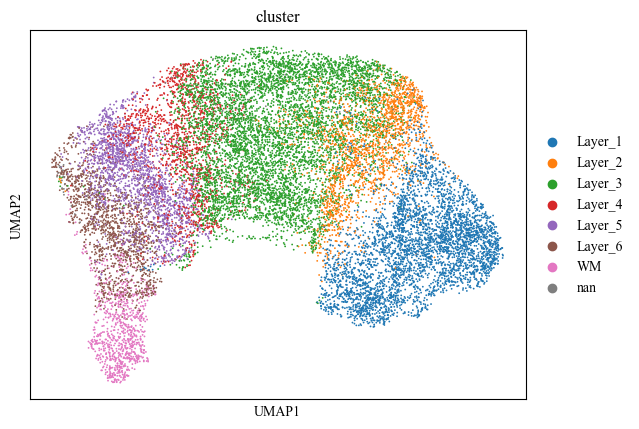

In [5]:
sc.pp.neighbors(adatas, use_rep='embedding')
sc.tl.umap(adatas)
sc.pl.umap(adatas, color=['cluster'])

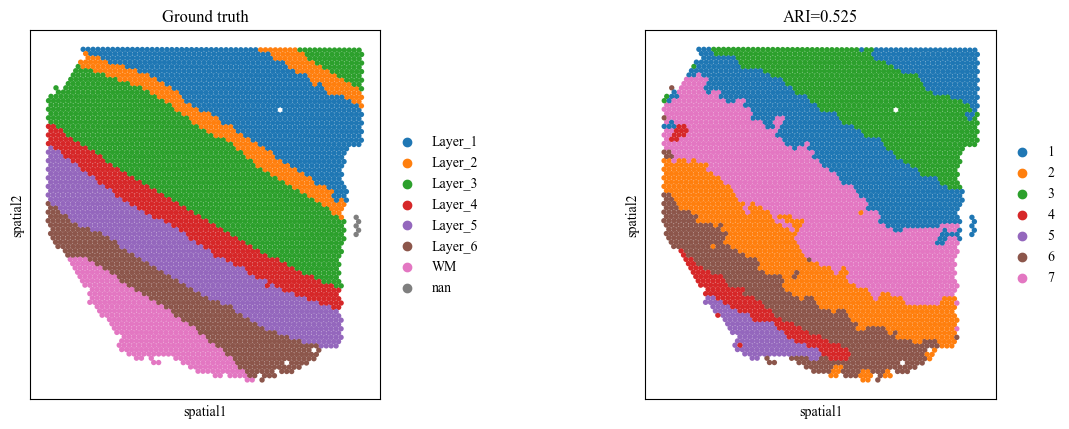

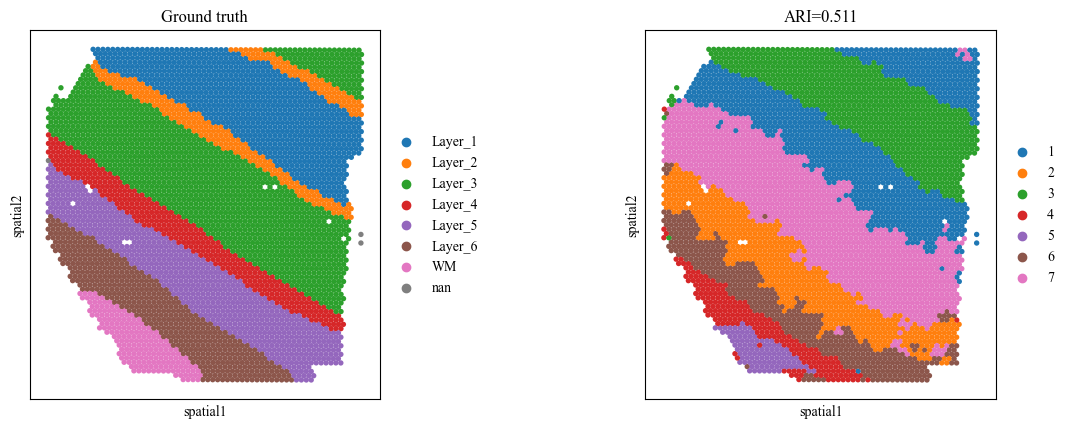

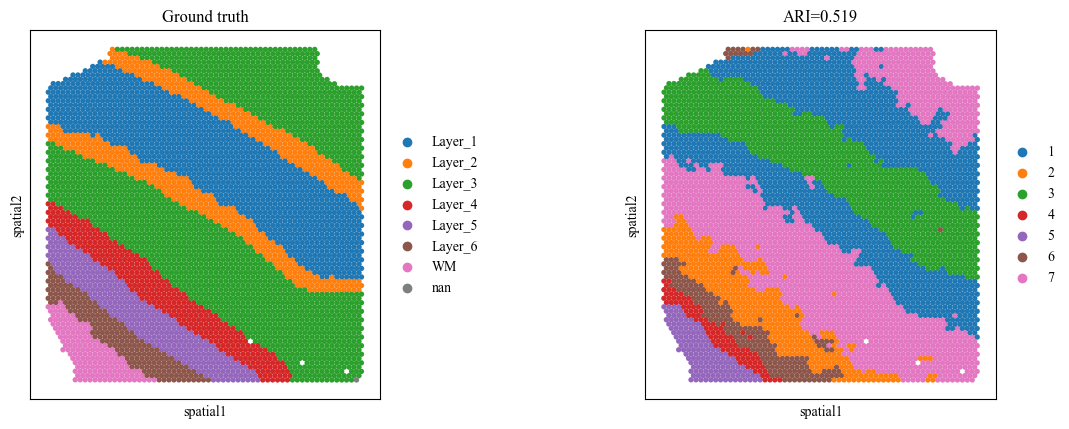

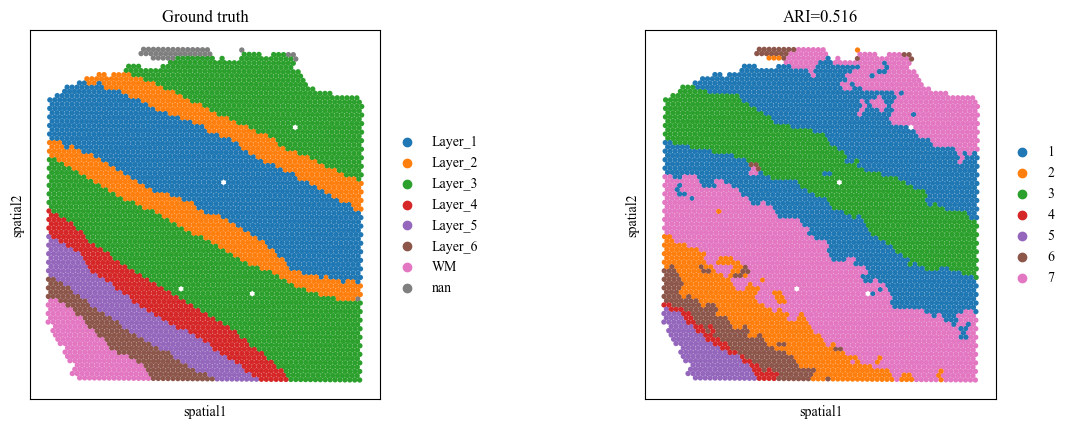

In [6]:
for i in range(4):
    adata = adatas[str(i) == adatas.obs['batch']]
    score = stds.cl.cal_cluster_score(adata.obs['cluster'], adata.obs['mclust'])
    sc.pl.spatial(adata, color=['cluster', 'mclust'], title=['Ground truth', f'ARI={score:.3f}'], spot_size=150)